<a href="https://colab.research.google.com/github/mohith-vishwanath/Simple_Pytorch_Image_Classifier/blob/main/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Necessary Imports**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, clear_output
import pandas as pd
import time
import json

from itertools import product
from collections import namedtuple
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import time

torch.set_printoptions(linewidth=120)
# torch.set_grad_enabled(False)

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.8.1+cu101
0.9.1+cu101


In [3]:
#Check if GPU is available
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
    print("GPU available")
else:
    device = "cpu"
    print("Only CPU available")

Only CPU available


### **Download FashionMNIST dataset**

In [ ]:
#Training set
train_set = torchvision.datasets.FashionMNIST(
    root = "",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [5]:
#Testing set
test_set = torchvision.datasets.FashionMNIST(
    root = "",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [6]:
#Number of data points for each class
train_set.targets.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [7]:
#Number of data points for each class
test_set.targets.bincount()

tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

### **Analysing Dataset**

Label : 9


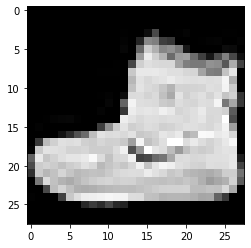

In [8]:
sample_iter = iter(train_set)
sample = next(sample_iter)
image, target = sample

plt.imshow(image.squeeze(),cmap="gray")
print("Label : " + str(target))

### **Helper Functions**

In [9]:
#This class returns all the combinations of hyperparameters with which the model needs to be trained

class RunBuilder:
    @staticmethod
    def get_runs(params):
        Runs = namedtuple("Run",params.keys())
        runs = []
        for v in product(*params.values()):
            runs.append(Runs(*v))
        return runs

In [10]:
class RunManager:
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None

        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None

        self.network = None
        self.loader = None
    
    def begin_run(self, run, network, loader):
        self.run_start_time = time.time()

        self.run_params = run
        self.run_count += 1

        self.network = network
        self.loader = loader

        images, labels = next(iter(self.loader))
    
    def end_run(self):
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()

        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)

        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results['loss'] = loss
        results["accuracy"] = accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)

        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
    
    def track_loss(self, loss, batch):
        self.epoch_loss += loss.item() * batch[0].shape[0]

    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self.get_num_correct(preds, labels)
    
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data, orient='columns'
        ).to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

### **The Neural Network**


In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)

        self.fc1 = nn.Linear(in_features=192,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=60)
        self.out = nn.Linear(in_features=60,out_features=10)
    

    def forward(self,t):
        #Layer1
        t = t

        #Layer2
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)

        #Layer3
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)

        #Layer4
        t = t.reshape(-1,12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        #Layer5
        t = self.fc2(t)
        t = F.relu(t)

        #Layer6
        t = self.out(t)
        # t = F.softmax(t)

        return t

In [43]:
network = Network() 
network = network.to(device)

num_of_epochs = 50

optimiser = optim.Adam(network.parameters(),lr=0.01)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=100,shuffle=True)
for e in range(1,num_of_epochs+1):
    total_loss = 0.0
    total_correct = 0
    start_time = time.time()
    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        pred = network(images)
        loss = F.cross_entropy(pred,labels)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        total_loss += loss.item()
        total_correct += get_num_correct_pred(pred,labels).item()

    end_time = time.time()

    print("Epoch : " + str(e) + " | accuracy : " + str(round((total_correct/len(train_set))*100,3)) + "% | loss : " + str(round(total_loss,5)) + " | time : " + str(round(end_time-start_time,4)) + "s")

Epoch : 1 | accuracy : 78.845% | loss : 338.4023 | time : 4.6358s
Epoch : 2 | accuracy : 86.145% | loss : 224.65034 | time : 4.645s
Epoch : 3 | accuracy : 87.365% | loss : 205.04975 | time : 4.5891s
Epoch : 4 | accuracy : 87.47% | loss : 200.90158 | time : 4.5193s
Epoch : 5 | accuracy : 87.925% | loss : 195.37557 | time : 4.6596s
Epoch : 6 | accuracy : 88.343% | loss : 187.39291 | time : 4.6996s
Epoch : 7 | accuracy : 88.437% | loss : 184.28281 | time : 4.5711s
Epoch : 8 | accuracy : 88.833% | loss : 180.80474 | time : 4.5869s
Epoch : 9 | accuracy : 88.633% | loss : 181.73404 | time : 4.5851s
Epoch : 10 | accuracy : 88.872% | loss : 182.07069 | time : 4.5806s
Epoch : 11 | accuracy : 89.067% | loss : 177.32943 | time : 4.5675s
Epoch : 12 | accuracy : 89.33% | loss : 173.18192 | time : 4.6801s
Epoch : 13 | accuracy : 89.302% | loss : 172.20611 | time : 4.5856s
Epoch : 14 | accuracy : 89.325% | loss : 173.22183 | time : 4.5696s
Epoch : 15 | accuracy : 89.58% | loss : 168.62854 | time : 4.

Testing the model

In [47]:
test_set_loader = torch.utils.data.DataLoader(test_set,batch_size=100,shuffle=True)
correct = 0
with torch.no_grad():
    for batch in test_set_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        preds = network(images)
        correct += get_num_correct_pred(preds,labels)

    result = (correct/len(test_set)).item()
    print(round(result,4)*100,"%")

88.21 %
